# Modelo DecisionTreeClassifier

In [31]:
# Importar librerías que usaremos en proceso del modelo con pyspark
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.session import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier

In [2]:
# Inicializar spark
sc = SparkContext("local[*]", "Decision Tree Classifier")
spark = SparkSession(sc)

21/12/08 20:10:21 WARN Utils: Your hostname, ubuntu resolves to a loopback address: 127.0.1.1; using 192.168.65.128 instead (on interface ens33)
21/12/08 20:10:21 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
21/12/08 20:10:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [7]:
# Cargar el dataset
data = spark.read.csv("diabetes.csv", inferSchema=True, header=True).toDF("PatientID","Pregnancies","PlasmaGlucose","DiastolicBloodPressure",
                                                                        "TricepsThickness","SerumInsulin","BMI","DiabetesPedigree","Age",
                                                                        "label")
dfr.show(5)

+---------+-----------+-------------+----------------------+----------------+------------+-----------+----------------+---+-----+
|PatientID|Pregnancies|PlasmaGlucose|DiastolicBloodPressure|TricepsThickness|SerumInsulin|        BMI|DiabetesPedigree|Age|label|
+---------+-----------+-------------+----------------------+----------------+------------+-----------+----------------+---+-----+
|  1354778|          0|          171|                    80|              34|          23|43.50972593|     1.213191354| 21|    0|
|  1147438|          8|           92|                    93|              47|          36|21.24057571|     0.158364981| 23|    0|
|  1640031|          7|          115|                    47|              52|          35|41.51152348|     0.079018568| 23|    0|
|  1883350|          9|          103|                    78|              25|         304|29.58219193|     1.282869847| 43|    1|
|  1424119|          1|           85|                    59|              27|          35|

### Indexamos la columna de label a labelIndex

In [4]:
l_indexer = StringIndexer(inputCol="label", outputCol="labelIndex")


### creamos un vectorassembler para vectorizar la data y luego la indexamos los vectores

In [5]:
vector_assembler = VectorAssembler(inputCols=["Pregnancies","PlasmaGlucose","DiastolicBloodPressure",
                  "TricepsThickness","SerumInsulin","BMI","DiabetesPedigree","Age"],outputCol="features")


In [10]:
vector_indexer =  VectorIndexer (inputCol="features",outputCol="indexedFeatures", maxCategories=4 )

### División de la data en data de entrenamiento y de prueba.

In [8]:
 
(training,testing) = data.randomSplit([0.7,0.3])

### creamos una funcio para realizar la clasificacion de arbol

In [9]:
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")

### Usamos Pipeline para realizar el fit y el transform del modelo

In [11]:
pipeline = Pipeline (stages= [l_indexer,vector_assembler,vector_indexer,dt])


In [12]:
fit_model = pipeline.fit(training)

In [13]:
result = fit_model.transform(testing)

In [21]:
result.select("prediction","labelIndex","features" ).show(5)

+----------+----------+--------------------+
|prediction|labelIndex|            features|
+----------+----------+--------------------+
|       0.0|       0.0|[0.0,92.0,24.0,11...|
|       0.0|       0.0|[1.0,53.0,59.0,37...|
|       1.0|       1.0|[2.0,131.0,74.0,4...|
|       0.0|       0.0|[0.0,101.0,53.0,8...|
|       1.0|       1.0|[3.0,105.0,67.0,3...|
+----------+----------+--------------------+
only showing top 5 rows



### clasificamo y evaluamos la data para concer el margen de error

In [26]:
evaluator = MulticlassClassificationEvaluator(labelCol="labelIndex", predictionCol="prediction",metricName="accuracy")
accuracy = evaluator.evaluate(result)

In [27]:
print("Test Error = %g " % (1.0 - accuracy))
print("Accuracy = %g " % accuracy)

Test Error = 0.11959 
Accuracy = 0.88041 


### modelo de arbol clasificado en IF

In [28]:
treeModel = fit_model.stages[3]

In [29]:
# Imprimir el modelo en con el DecisionTreeClassifier en pyspark mediante un árbol de decisiones de ciclos if-else

print(treeModel.toDebugString)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_cdb2d14da905, depth=5, numNodes=45, numClasses=2, numFeatures=8
  If (feature 0 <= 1.5)
   If (feature 7 <= 35.5)
    If (feature 1 <= 172.5)
     Predict: 0.0
    Else (feature 1 > 172.5)
     If (feature 7 <= 23.5)
      If (feature 6 <= 0.14590652850000002)
       Predict: 1.0
      Else (feature 6 > 0.14590652850000002)
       Predict: 0.0
     Else (feature 7 > 23.5)
      If (feature 5 <= 49.283672609999996)
       Predict: 0.0
      Else (feature 5 > 49.283672609999996)
       Predict: 1.0
   Else (feature 7 > 35.5)
    If (feature 0 <= 0.5)
     If (feature 4 <= 311.5)
      If (feature 6 <= 1.3381002785)
       Predict: 0.0
      Else (feature 6 > 1.3381002785)
       Predict: 1.0
     Else (feature 4 > 311.5)
      If (feature 5 <= 38.72266718)
       Predict: 1.0
      Else (feature 5 > 38.72266718)
       Predict: 0.0
    Else (feature 0 > 0.5)
     If (feature 5 <= 21.86856788)
      Predict: 0.0
     Else (featur

## Graficar DecisionTreeClassifier

In [84]:
# Importar librerías para graficar un modelo en sklearn para visualizar cómo se vería 
# un DecissionTreeClassifier graficado

from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

In [85]:
data = pd.read_csv('diabetes.csv')

In [86]:
# Limpiar la data

data = data.dropna()

In [87]:
# Guardar en "predictors" los datos a evaluar y en "targets" el label que servirá como punto
# de comparación

predictors = data[["Pregnancies","PlasmaGlucose","PlasmaGlucose","DiastolicBloodPressure",
                  "TricepsThickness","SerumInsulin","BMI","DiabetesPedigree","Age"]]
targets = data.Diabetic

In [88]:
# Guardar en "predictors_labels" los datos a evaluar y en "targets_labels" el los valores que contiene
# el label que servirá como punto de comparación

predictors_labels=["Pregnancies","PlasmaGlucose","PlasmaGlucose","DiastolicBloodPressure",
                  "TricepsThickness","SerumInsulin","BMI","DiabetesPedigree","Age"]
targets_labels=['1','0']

In [89]:
# Dividir la data en data de entrenamiento y prueba.
X_train, X_test, y_train, y_test = train_test_split(predictors, targets)

In [90]:
# Implementar el DecisionTreeClassifier con un grado de profundidad de 7

arbol = DecisionTreeClassifier(max_depth=7)

In [91]:
# Enternar el modelo
arbol.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7)

In [93]:
# Asertividad del modelo con data de prueba

arbol.score(X_test, y_test)

0.9036

In [94]:
# Asertividad del modelo con data de entrenamiento

arbol.score(X_train, y_train)

0.9290666666666667

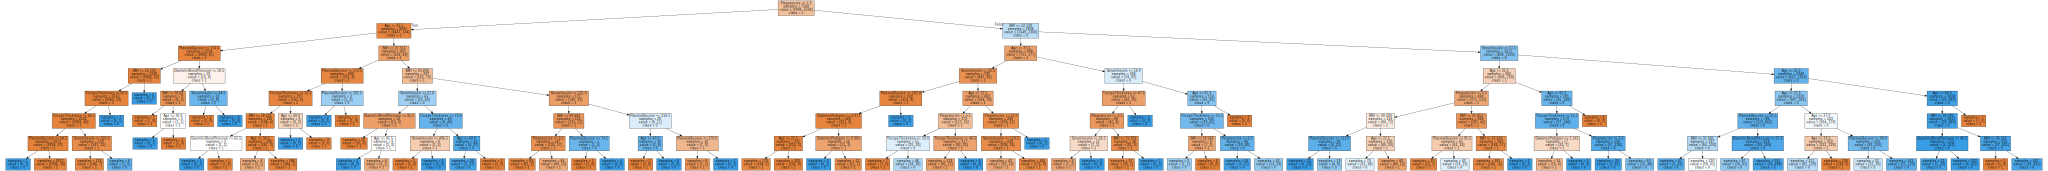

In [95]:
#Graficar el árbol de decisiones de clasificación

export_graphviz(arbol,out_file='arbol.dot',class_names=targets_labels,
               feature_names=predictors_labels,impurity=False,filled=True)

with open('arbol.dot') as f:
    dot_graph=f.read()
graphviz.Source(dot_graph)